In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score

In [2]:
# Load UCI breast cancer dataset with column names and remove ID column
uci_bc_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", 
    sep=",",
    header=None,
    names=[
        "id_number", "diagnosis", "radius_mean",
        "texture_mean", "perimeter_mean", "area_mean",
        "smoothness_mean", "compactness_mean",
        "concavity_mean","concave_points_mean",
        "symmetry_mean", "fractal_dimension_mean",
        "radius_se", "texture_se", "perimeter_se",
        "area_se", "smoothness_se", "compactness_se",
        "concavity_se", "concave_points_se",
        "symmetry_se", "fractal_dimension_se",
        "radius_worst", "texture_worst",
        "perimeter_worst", "area_worst",
        "smoothness_worst", "compactness_worst",
        "concavity_worst", "concave_points_worst",
        "symmetry_worst", "fractal_dimension_worst"
    ],).drop("id_number", axis=1)

y = uci_bc_data.diagnosis.map({"B": 0, "M": 1}).to_numpy()
X = uci_bc_data.drop("diagnosis", axis=1).to_numpy()

In [5]:
ps = np.linspace(0, 0.25, 5)
qdas_2 = np.zeros(len(ps))
rfcs_2 = np.zeros(len(ps))
qdas_3 = np.zeros(len(ps))
rfcs_3 = np.zeros(len(ps))
mislabeled_score = np.zeros([5, 6])
N = 20
B = 50
rfc = RandomForestClassifier()

true_recall_p = []
mislabeled_recall_p = []

In [6]:
for i, p in enumerate(ps):
    confidence_count = [[] for _ in range(len(y))]
    pos_flip = np.random.randint((len(y)-1), size = int(np.round(p*len(y))))
    y_flip = y.copy()
    y_flip[pos_flip] -= 1
    y_flip[pos_flip] *= -1

    true_recall = []
    mislabeled_recall = []

    for j in range(N):
        (
            X_train, 
            X_val, 
            y_train, 
            y_val, 
            train_idx, 
            val_idx) = train_test_split(
                X, 
                y_flip,
                np.arange(len(X)), 
                stratify=y_flip, 
                test_size=0.25, 
                train_size=0.75)

        for b in range(B):
            rfc.fit(X_train, y_train)
            
            preds = rfc.predict(X_val)
            for k, pos in enumerate(val_idx):
                confidence_count[pos].append(preds[k])
            
            true_recall.append(recall_score(y[val_idx], preds))
            mislabeled_recall.append(recall_score(y_val, preds))

    confidence = [sum(observation) / len(observation) if observation != [] else np.nan for observation in confidence_count]

    true_recall_p.append(np.array(true_recall).mean())
    mislabeled_recall_p.append(np.array(mislabeled_recall).mean())

    corrected_labels = 0
    print(f'p = {p}')
    print('Performance:')
    print(f'    True targets => Average recall = {np.array(true_recall).mean()}')
    print(f'    Mislabeled targets => Average recall = {np.array(mislabeled_recall).mean()}')

    t = PrettyTable(['True label', 'Labeled as', 'Confidence', 'Winning class'])
    for conf, y_true, y_mis in zip(confidence, y, y_flip):
        if y_true != y_mis:
            winning_class = 1 if conf > 0.5 else 0
            if winning_class == y_true:
                corrected_labels += 1
            t.add_row([y_true, y_mis, conf, winning_class])

    print(f'Corrected {corrected_labels}/{len(pos_flip)} of mislabeled observations')

    print('Result of mislabeled observations:')
    print(t)
    print('======================================================================')

p = 0.0
Performance:
    True targets => Average recall = 0.9325094339622642
    Mislabeled targets => Average recall = 0.9325094339622642
Corrected 0/0 of mislabeled observations
Result of mislabeled observations:
+------------+------------+------------+---------------+
| True label | Labeled as | Confidence | Winning class |
+------------+------------+------------+---------------+
+------------+------------+------------+---------------+
p = 0.0625
Performance:
    True targets => Average recall = 0.9357671229431148
    Mislabeled targets => Average recall = 0.8597636363636364
Corrected 30/36 of mislabeled observations
Result of mislabeled observations:
+------------+------------+------------+---------------+
| True label | Labeled as | Confidence | Winning class |
+------------+------------+------------+---------------+
|     1      |     0      |    1.0     |       1       |
|     1      |     0      |    1.0     |       1       |
|     1      |     0      |    0.0     |       0    

Text(0.5, 1.0, 'Recall as a function of p')

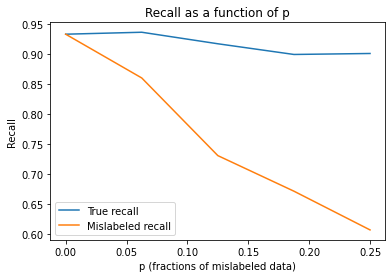

In [12]:
plt.plot(ps, true_recall_p)
plt.plot(ps, mislabeled_recall_p)
plt.legend(['True recall', 'Mislabeled recall'])
plt.xlabel('p (fractions of mislabeled data)')
plt.ylabel('Recall')
plt.title('Recall as a function of p')